# Predicting Football Results with Statistical Modelling

### Poisson Distribution

The model is founded on the number of goals scored/conceded by each team. Teams that have been higher scorers in the past have a greater likelihood of scoring goals in the future. We'll import all match results from the Serie A 2022/23 season.

https://www.football-data.co.uk/italym.php


In [53]:
# https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-06-04-predicting-football-results-with-statistical-modelling.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam

sa_2223 = pd.read_csv("sa-2223.csv")
sa_2223 = sa_2223[['HomeTeam','AwayTeam','FTHG','FTAG']]
sa_2223 = sa_2223.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
sa_2223.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Milan,Udinese,4,2
1,Sampdoria,Atalanta,0,2
2,Lecce,Inter,1,2
3,Monza,Torino,1,2
4,Fiorentina,Cremonese,3,2


We imported a csv as a pandas dataframe, which contains various information for each of the 380 Seria A games in the 2022-23 First Italian League season. We restricted the dataframe to the columns in which we're interested (specifically, team names and numer of goals scored by each team).

In [3]:
sa_2223 = sa_2223[:-10] # Extract the last ten games
sa_2223.mean(numeric_only=True)

HomeGoals    1.400
AwayGoals    1.125
dtype: float64

You'll notice that, on average, the home team scores more goals than the away team. This is the so called 'home (field) advantage' (discussed [here](https://jogall.github.io/2017-05-12-home-away-pref/)) and [isn't specific to soccer](http://bleacherreport.com/articles/1803416-is-home-field-advantage-as-important-in-baseball-as-other-major-sports). This is a convenient time to introduce the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution). It's a discrete probability distribution that describes the probability of the number of events within a specific time period (e.g 90 mins) with a known average rate of occurrence. A key assumption is that the number of events is independent of time. In our context, this means that goals don't become more/less likely by the number of goals already scored in the match. Instead, the number of goals is expressed purely as function an average rate of goals. If that was unclear, maybe this mathematical formulation will make clearer:

$$
P\left( x \right) = \frac{e^{-\lambda} \lambda ^x }{x!}, \lambda>0
$$

$\lambda$ represents the average rate (e.g. average number of goals, average number of letters you receive, etc.). So, we can treat the number of goals scored by the home and away team as two independent Poisson distributions. The plot below shows the proportion of goals scored compared to the number of goals estimated by the corresponding Poisson distributions.

In [49]:
# construct Poisson for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, sa_2223[['HomeGoals', 'AwayGoals']].mean(numeric_only=True)[j]) for i in range(8)] for j in range(2)])

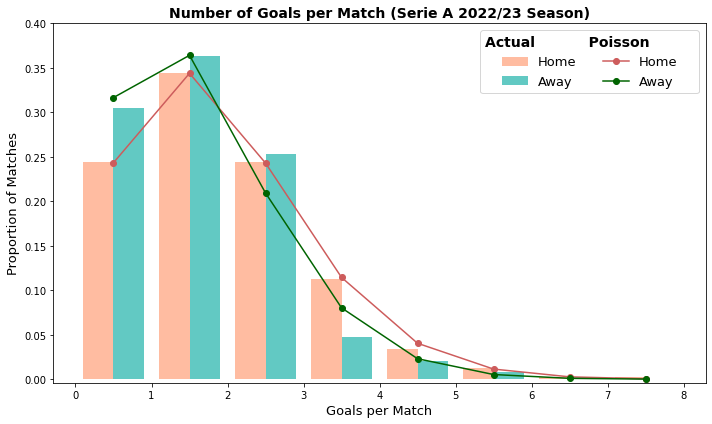

In [51]:
# Set the figure size for a larger plot
plt.figure(figsize=(10, 6))  # Adjust the size as needed

# Plot histogram of actual goals
plt.hist(sa_2223[['HomeGoals', 'AwayGoals']].values, bins=range(9), 
         alpha=0.7, label=['Home', 'Away'], density=True, color=["#FFA07A", "#20B2AA"])

# Add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

# Customize the legend
leg = plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Actual           Poisson         ", prop = {'size':'14', 'weight':'bold'})

# Set ticks, labels, and title
plt.xticks([i for i in range(9)], [i for i in range(9)])
plt.xlabel("Goals per Match", size=13)
plt.ylabel("Proportion of Matches", size=13)
plt.title("Number of Goals per Match (Serie A 2022/23 Season)", size=14, fontweight='bold')
plt.ylim([-0.004, 0.4])

# Tight layout for a neat presentation
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('goals_per_match_serie_a_2223.pdf', bbox_inches='tight')

# Display the plot
plt.show()

We can use this statistical model to estimate the probability of specfic events. For example the probability of the home team to score 2 goals.

$$
\begin{align*}
P(\geq 2|Home) &= P(2|Home) + P(3|Home) + ...\\
        &= 0.258 + 0.137 + ...\\
        &= 0.47
\end{align*}
$$

The probability of a draw is simply the sum of the events where the two teams score the same amount of goals.

$$
\begin{align*}
P(Draw) &= P(0|Home) \times P(0|Away) + P(1|Home) \times P(1|Away) + ...\\
        &= 0.203 \times 0.306 + 0.324 \times 0.362 + ...\\
        &= 0.248
\end{align*}
$$

Note that we consider the number of goals scored by each team to be independent events (i.e. P(A n B) = P(A) P(B)). The difference of two Poisson distribution is actually called a [Skellam distribution](https://en.wikipedia.org/wiki/Skellam_distribution). So we can calculate the probability of a draw by inputting the mean goal values into this distribution.

In [19]:
# probability of draw between home and away team
skellam.pmf(0.0,  sa_2223.mean(numeric_only=True)[0],  sa_2223.mean(numeric_only=True)[1])

0.26336000523297276

The probability of a draw (i.e., **both teams scoring the same number of goals**) is estimated using the Skellam distribution. The Skellam distribution's pmf is calculated at 0 (skellam.pmf(`0.0`, mean_home, mean_away)), which signifies that the difference in goals scored by the home and away teams is zero.

In [20]:
# probability of home team winning by one goal
skellam.pmf(1,  sa_2223.mean(numeric_only=True)[0],  sa_2223.mean(numeric_only=True)[1])

0.22487913595916245

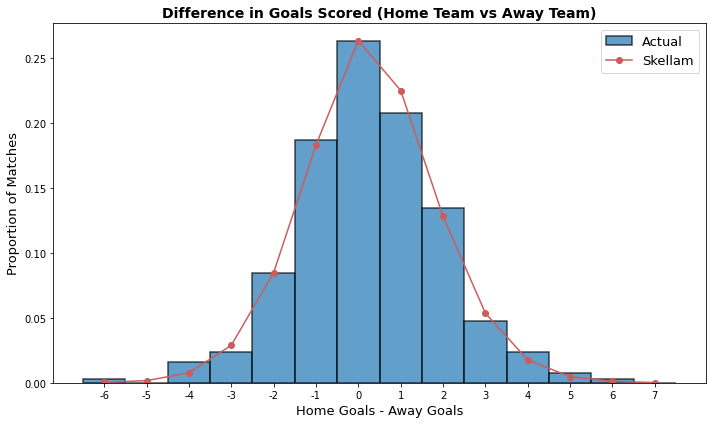

In [45]:
skellam_pred = [skellam.pmf(i,  sa_2223.mean(numeric_only=True)[0],  sa_2223.mean(numeric_only=True)[1]) for i in range(-6,8)]

# Set the figure size for a larger plot
plt.figure(figsize=(10, 6))

# Adjusting the histogram for goal differences and replacing 'normed' with 'density'
plt.hist(sa_2223['HomeGoals'].values - sa_2223['AwayGoals'].values, bins=np.arange(-6.5, 8, 1), 
         alpha=0.7, label='Actual', density=True, edgecolor='black', linewidth=1.5)

# Adding Skellam distribution predictions
plt.plot(np.arange(-6, 8), skellam_pred,
         linestyle='-', marker='o', label="Skellam", color = '#CD5C5C')

# Adding legend, labels, and title
plt.legend(loc='upper right', fontsize=13)
plt.xticks(np.arange(-6, 8), np.arange(-6, 8))
plt.xlabel("Home Goals - Away Goals", size=13)
plt.ylabel("Proportion of Matches", size=13)
plt.title("Difference in Goals Scored (Home Team vs Away Team)", size=14, fontweight='bold')

# Automatically adjust y-axis limits
# plt.ylim([-0.004, 0.26])  # This line is commented out to let Matplotlib adjust automatically

# Tight layout for a neat presentation
plt.tight_layout()

# Save the figure as a PDF before showing it
plt.savefig('difference_in_goals_serie_a_2223.pdf', bbox_inches='tight')

# Display the plot
plt.show()

So, hopefully you can see how we can adapt this approach to model specific matches. We just need to know the average number of goals scored by each team and feed this data into a Poisson model. 

Let's have a look at the distribution of goals scored by Napoli and Sampdoria(teams who finished 1st and last, respectively).

Let's start by calculating the actual distribution of goals scored by Napoli and Sampdoria, both at home and away, in the Serie A 2022/23 season.

In [60]:
# Calculate the actual goal distribution for Napoli and Sampdoria at home
nap_home = sa_2223[sa_2223['HomeTeam'] == 'Napoli']['HomeGoals'].value_counts(normalize=True).sort_index()
samp_home = sa_2223[sa_2223['HomeTeam'] == 'Sampdoria']['HomeGoals'].value_counts(normalize=True).sort_index()

In [65]:
# Calculate the actual goal distribution for Napoli and Sampdoria away
nap_away = sa_2223[sa_2223['AwayTeam'] == 'Napoli']['AwayGoals'].value_counts(normalize=True).sort_index()
samp_away = sa_2223[sa_2223['AwayTeam'] == 'Sampdoria']['AwayGoals'].value_counts(normalize=True).sort_index()

Then we calculate the expected distribution based on the Poisson statistical model, using the mean number of goals scored by each team in their respective home and away games.

In [64]:
# Calculate Poisson distribution for the average goals scored at home
nap_home_mean = sa_2223[sa_2223['HomeTeam'] == 'Napoli']['HomeGoals'].mean()
samp_home_mean = sa_2223[sa_2223['HomeTeam'] == 'Sampdoria']['HomeGoals'].mean()

nap_home_pois = [poisson.pmf(i, nap_home_mean) for i in range(8)]
samp_home_pois = [poisson.pmf(i, samp_home_mean) for i in range(8)]

In [66]:
# Calculate Poisson distribution for the average goals scored away
nap_away_mean = sa_2223[sa_2223['AwayTeam'] == 'Napoli']['AwayGoals'].mean()
samp_away_mean = sa_2223[sa_2223['AwayTeam'] == 'Sampdoria']['AwayGoals'].mean()
nap_away_pois = [poisson.pmf(i, nap_away_mean) for i in range(8)]
samp_away_pois = [poisson.pmf(i, samp_away_mean) for i in range(8)]

Plot these distributions for comparison, with separate subplots for home and away goal distributions.

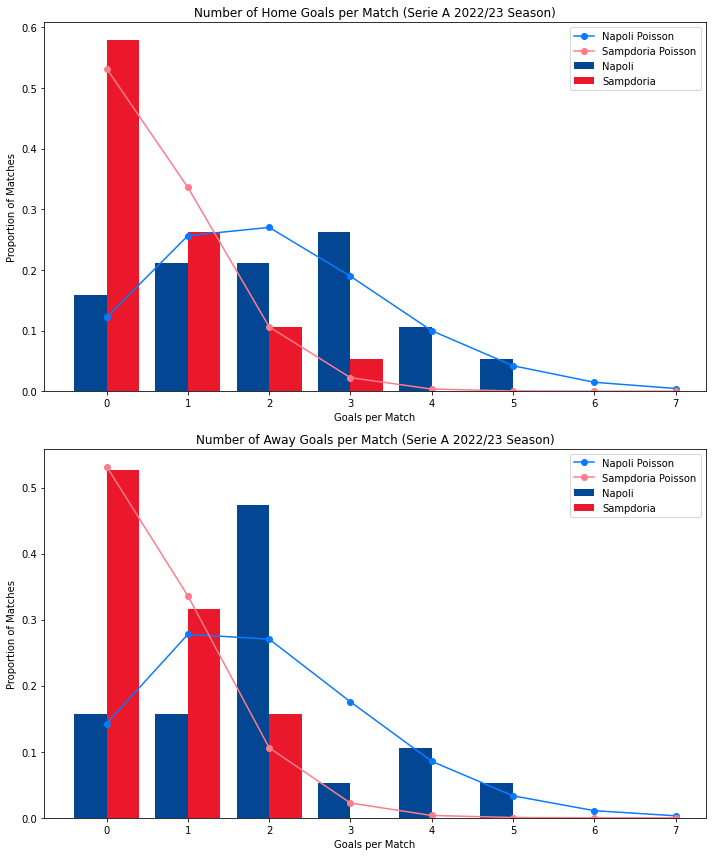

In [68]:
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Home Goals
axes[0].bar(nap_home.index - 0.2, nap_home.values, width=0.4, color="#034694", label="Napoli")
axes[0].bar(samp_home.index + 0.2, samp_home.values, width=0.4, color="#EB172B", label="Sampdoria")
axes[0].plot([i for i in range(8)], nap_home_pois, linestyle='-', marker='o', label="Napoli Poisson", color="#0a7bff")
axes[0].plot([i for i in range(8)], samp_home_pois, linestyle='-', marker='o', label="Sampdoria Poisson", color="#ff7c89")
axes[0].set_title("Number of Home Goals per Match (Serie A 2022/23 Season)")
axes[0].set_xlabel("Goals per Match")
axes[0].set_ylabel("Proportion of Matches")
axes[0].legend()

# Away Goals
axes[1].bar(nap_away.index - 0.2, nap_away.values, width=0.4, color="#034694", label="Napoli")
axes[1].bar(samp_away.index + 0.2, samp_away.values, width=0.4, color="#EB172B", label="Sampdoria")
axes[1].plot([i for i in range(8)], nap_away_pois, linestyle='-', marker='o', label="Napoli Poisson", color="#0a7bff")
axes[1].plot([i for i in range(8)], samp_away_pois, linestyle='-', marker='o', label="Sampdoria Poisson", color="#ff7c89")
axes[1].set_title("Number of Away Goals per Match (Serie A 2022/23 Season)")
axes[1].set_xlabel("Goals per Match")
axes[1].set_ylabel("Proportion of Matches")
axes[1].legend()

# Save the figure as a PDF before showing it
plt.savefig('goal_distribution_home-away_serie_a_2223.pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()

## Building A Model

You should now be convinced that the number of goals scored by each team can be approximated by a Poisson distribution. Due to a relatively sample size (each team plays at most 19 home/away games), the accuracy of this approximation can vary significantly (especially earlier in the season when teams have played fewer games). Similar to before, we could now calculate the probability of various events in this Napoli Sampdoria match. But rather than treat each match separately, we'll build a more general Poisson regression model ([what is that?](https://en.wikipedia.org/wiki/Poisson_regression)).

In [75]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

1. **Importing Libraries**:
   - `statsmodels.api` and `statsmodels.formula.api` are imported to facilitate statistical modeling. `statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration.

In [ ]:
goal_model_data = pd.concat([sa_2223[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           sa_2223[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

2. **Preparing the Data**:
   - The dataset `sa_2223` contains Serie A match data, with columns for the home team, away team, home goals, and away goals.
   - The code then creates a single DataFrame `goal_model_data` from `sa_2223` where each row represents one team's perspective of a match. It doubles the number of rows in the dataset: one row for each team in each match, labeling one as `home=1` (home team perspective) and the other as `home=0` (away team perspective). This restructuring facilitates the modeling of goals scored as a function of being the home team or the away team and the specific opponent.
   - Columns are renamed for clarity: `HomeTeam` and `AwayTeam` to `team` and `opponent`, respectively, and `HomeGoals` and `AwayGoals` to a common `goals` column to indicate the number of goals scored by the `team`.

In [77]:
goal_model_data

,team,opponent,goals,home
0,Milan,Udinese,4,1
1,Sampdoria,Atalanta,0,1
2,Lecce,Inter,1,1
3,Monza,Torino,1,1
4,Fiorentina,Cremonese,3,1
...,...,...,...,...
375,Monza,Atalanta,2,0
376,Bologna,Lecce,3,0
377,Verona,Milan,1,0
378,Spezia,Roma,1,0


In [78]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

3. **Constructing the Poisson Regression Model**:
   - A generalized linear model (GLM) with a Poisson family is used to model the count data (`goals`), which is typical for this type of prediction model where the outcome variable is the count of events (goals in this case) that occur in fixed intervals of time or space.
   - The formula `goals ~ home + team + opponent` specifies that the number of goals is predicted by whether the team is playing at home or away, the team itself, and the opponent.
   - `smf.glm` is used to fit the model, indicating a generalized linear model fitting procedure. The `family=sm.families.Poisson()` parameter specifies that a Poisson distribution is assumed for the response variable (the number of goals).

In [79]:
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  760
Model:                            GLM   Df Residuals:                      720
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1028.8
Date:                Tue, 20 Feb 2024   Deviance:                       735.38
Time:                        09:23:54   Pearson chi2:                     635.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1741
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.4509      0.196      2.301      0.021       0.067       0.835
team[T.Bologna]            -0.2190      0.185     -1.185      0.236      -0.581       0.143
team[T.Cremonese]          -0.5851      0.208     -2.819      0.005      -0.992      -0.178
team[T.Empoli]             -0.5793      0.206     -2.817      0.005      -0.982      -0.176
team[T.Fiorentina]         -0.2256      0.185     -1.221      0.222      -0.588       0.137
team[T.Inter]               0.0667      0.171      0.389      0.697      -0.269       0.402
team[T.Juventus]           -0.1812      0.182     -0.996      0.319      -0.538       0.175
team[T.Lazio]              -0.1153      0.179     -0.645      0.519      -0.465       0.235
team[T.Lecce]              -0.6971      0.213     -3.266      0.001      -1.116      -0.279
team[T.Milan]              -0.0364      0.176     -0.207      0.836      -0.381       0.308
team[T.Monza]              -0.3151      0.190     -1.659      0.097      -0.688       0.057
team[T.Napoli]              0.1326      0.168      0.789      0.430      -0.197       0.462
team[T.Roma]               -0.2894      0.188     -1.541      0.123      -0.657       0.079
team[T.Salernitana]        -0.3042      0.190     -1.601      0.109      -0.677       0.068
team[T.Sampdoria]          -0.9894      0.239     -4.146      0.000      -1.457      -0.522
team[T.Sassuolo]           -0.3264      0.191     -1.707      0.088      -0.701       0.048
team[T.Spezia]             -0.7426      0.218     -3.406      0.001      -1.170      -0.315
team[T.Torino]             -0.4609      0.198     -2.332      0.020      -0.848      -0.073
team[T.Udinese]            -0.3406      0.191     -1.782      0.075      -0.715       0.034
team[T.Verona]             -0.7459      0.218     -3.421      0.001      -1.173      -0.319
opponent[T.Bologna]         0.0064      0.203      0.031      0.975      -0.392       0.405
opponent[T.Cremonese]       0.3311      0.188      1.759      0.079      -0.038       0.700
opponent[T.Empoli]         -0.0109      0.203     -0.054      0.957      -0.410       0.388
opponent[T.Fiorentina]     -0.1246      0.210     -0.593      0.554      -0.537       0.288
opponent[T.Inter]          -0.1285      0.212     -0.607      0.544      -0.543       0.286
opponent[T.Juventus]       -0.3867      0.226     -1.708      0.088      -0.831       0.057
opponent[T.Lazio]          -0.4779      0.233     -2.051      0.040      -0.935      -0.021
opponent[T.Lecce]          -0.0785      0.207     -0.380      0.704      -0.483       0.326
opponent[T.Milan]          -0.1126      0.210     -0.535      0.592      -0.525       0.300
opponent[T.Monza]           0.0605      0.201      0.302      0.763      -0.332       0.454
opponent[T.Napoli]         -0.5286      0.238  

4. **Model Summary**:
   - `poisson_model.summary()` provides a summary of the regression model, including coefficients for each predictor and statistics that can help in evaluating the model's performance and the significance of predictors.


### Basic Model Information
- **Dependent Variable (goals)**: The number we're predicting – how many goals a team scores.
- **Number of Observations (760)**: Total matches analyzed.
- **Model (GLM with Poisson family)**: A statistical approach for count data (like goals) where outcomes are counts or can vary from 0 to infinity and are not normally distributed.
- **Link Function (Log)**: Transforms the prediction to ensure it's always positive, because you can't score negative goals.

### Fit Quality
- **Log-Likelihood**: This number (-1028.8) tells us how likely our data is, given the model. Higher (less negative) means better.
- **Deviance and Pearson chi2**: These are technical measures indicating how well the model fits the data. Lower numbers mean a better fit.
- **Pseudo R-squared (0.1741)**: Shows how much variance the model explains. Closer to 1 means better, but for count data models, this number is often lower than in linear regression.

### Coefficients (the effect of each predictor)
Each row after "coef" shows the impact of different teams and playing at home (or not) on the number of goals scored. 

- **Intercept (Atalanta's baseline)**: With a coefficient of 0.4509, this is the log of the expected number of goals scored by Atalanta at home against an average team. Because it's positive, it indicates they're expected to score goals.

- **Team Effects**: Each "team[T.XXX]" row shows how much more or less each team is expected to score compared to Atalanta (the baseline because of alphabetical order), holding other factors constant. For example, "team[T.Cremonese] -0.5851" means Cremonese scores fewer goals compared to Atalanta, given the same conditions.

- **Opponent Effects**: Each "opponent[T.XXX]" row shows the effect of each team as an opponent. For example, "opponent[T.Napoli] -0.5286" means teams score fewer goals when playing against Napoli, indicating Napoli has a strong defense.

- **Home Effect (home)**: With a coefficient of 0.2061, playing at home increases the log count of expected goals by this amount. This indicates a home advantage in scoring goals.

  If you're curious about the `smf.glm(...)` part, you can find more information [here](http://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html) (edit: earlier versions of this post had erroneously employed a Generalised Estimating Equation (GEE)- [what's the difference](https://stats.stackexchange.com/questions/16390/when-to-use-generalized-estimating-equations-vs-mixed-effects-models)). I'm more interested in the values presented in the `coef` column in the model summary table, which are analogous to the slopes in linear regression. Similar to [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), we take the [exponent of the parameter values](http://www.lisa.stat.vt.edu/sites/default/files/Poisson.and_.Logistic.Regression.pdf).

A positive value implies more goals ($e^{x}>1 \forall x > 0$), while values closer to zero represent more neutral effects ($e^{0}=1$). Towards the bottom of the table you might notice that `home` has a `coef` of 0.2061. This captures the fact that home teams generally score more goals than the away team (specifically, $e^{0.2061}$=1.23 times more likely). But not all teams are created equal. Napoli has an estimate of `0.1326`, while the corresponding value for Sampdoria is `-0.9894` (sort of saying Napoli (Sampdoria) are better (much worse!) scorers than average). 

Finally, the `opponent*` values penalize/reward teams based on the quality of the opposition. This reflects the defensive strength of each team (Napoli: `-0.5286`; Sampdoria: `0.3467`). In other words, you're less likely to score against Napoli. Hopefully, that all makes both statistical and intuitive sense.

### Statistical Significance
- **P>|z|**: This column tells us the probability that the coefficient is different from 0 purely by chance. A value under 0.05 (like for "team[T.Cremonese]") suggests strong evidence that the team really does have an effect on the number of goals scored, not just by random chance.

### Confidence Intervals ([0.025 0.975])
These columns provide a range of values that are likely to contain the true effect of each predictor on the number of goals scored. For instance, for "Intercept", we are 95% confident the true value lies between 0.067 and 0.835.

In essence, this model is trying to understand how much playing at home, the specific team, and the opponent team affect the number of goals scored in a match. It uses the history of goals scored in matches to estimate these effects.

## Making Predictions

Let's start making some predictions. We simply pass our teams into poisson_model and it'll return the expected average number of goals for your team (we need to run it twice- we calculate the expected average number of goals for each team separately). So let's see how many goals we expect Napoli and Sampdoria to score.

#### **Napoli - Sampdoria: ? - ?**

In [80]:
# predicts the number of goals Napoli is expected to score when playing against Sampdoria at home
poisson_model.predict(pd.DataFrame(data={'team': 'Napoli', 'opponent': 'Sampdoria',
                                       'home':1},index=[1]))

1    3.115342
dtype: float64

1. **Making Predictions for Napoli (home effect)**:
   - The first `poisson_model.predict()` call predicts the number of goals Napoli is expected to score when playing against Sampdoria at home (`'home':1` indicates Napoli is playing at home).
   - You create a DataFrame with the specific match setup you're interested in: Napoli as the `team`, Sampdoria as the `opponent`, and Napoli playing at home.
   - The model then uses the coefficients it learned during training (like the effects of being Napoli, playing against Sampdoria, and the advantage of playing at home) to calculate the expected number of goals.

In [81]:
# predicts how many goals Sampdoria might score when they are away against Napoli
poisson_model.predict(pd.DataFrame(data={'team': 'Sampdoria', 'opponent': 'Napoli',
                                       'home':0},index=[1]))

1    0.344024
dtype: float64

2. **Making Predictions for Sampdoria (opponent effect)**:
   - The second `poisson_model.predict()` call does the opposite. It predicts how many goals Sampdoria might score when they are away (`'home':0` indicates Sampdoria is playing away) against Napoli.
   - This time, the DataFrame is set up with Sampdoria as the `team` and Napoli as the `opponent`, with Sampdoria playing away.
   - Again, the model uses its learned coefficients to estimate the goals, but this time considering Sampdoria's performance, Napoli's defensive capabilities, and the fact that Sampdoria is not playing at home.

Just like before, we have two Poisson distributions. From this, we can calculate the probability of various events. I'll wrap this in a `simulate_match` function.

In [83]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    # predicts the number of goals homeTeam is expected to score when playing against awayTeam
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    # predicts how many goals awayTeam might score when they are against homeTeam
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    # Calculating the Poisson Distribution for Predicted Averages
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    # Calculating the Match Outcome Probabilities
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
    
simulate_match(poisson_model, 'Napoli', 'Sampdoria', max_goals=3)

array([[0.03144969, 0.01081945, 0.00186108, 0.00021342],
       [0.09797654, 0.0337063 , 0.00579789, 0.00066487],
       [0.15261522, 0.05250332, 0.0090312 , 0.00103565],
       [0.15848286, 0.05452193, 0.00937843, 0.00107547]])

This matrix simply shows the probability of Napoli (rows of the matrix) and Sampdoria (matrix columns) scoring a specific number of goals.

For example, along the diagonal, both teams score the same the number of goals (e.g. P(0-0)=0.031). So, you can calculate the odds of draw by summing all the diagonal entries. Everything below the diagonal represents a Napoli victory (e.g P(3-0)=0.158), And you can estimate P(Over 2.5 goals) by summing all entries except the four values in the upper left corner. Luckily, we can use basic matrix manipulation functions to perform these calculations.

This `simulate_match` function is designed to simulate the outcome of a football match between two specified teams using a Poisson regression model. It estimates the probabilities of all possible scorelines up to a maximum number of goals. Here's a breakdown of how it works:

1. **Inputs to the Function**:
   - `foot_model`: This is the Poisson regression model we've built and trained to predict the number of goals based on the team playing, their opponent, and whether they're playing at home.
   - `homeTeam` and `awayTeam`: The names of the teams playing the match, with `homeTeam` being the one playing at home.
   - `max_goals`: The maximum number of goals to consider for each team. It sets a limit for the scoreline prediction range.

2. **Predicting Average Goals**:
   - The function first uses the model to predict the average number of goals expected to be scored by the home team against the away team and vice versa. It does this by feeding the model a DataFrame for each scenario, indicating the teams involved and whether they're playing at home or away.
   - `home_goals_avg` and `away_goals_avg` capture these predicted averages.

3. **Calculating the Poisson Distribution for Predicted Averages**:
   - For each team, it calculates the probability of scoring 0 to `max_goals` goals based on the predicted averages. This uses the Poisson probability mass function (`poisson.pmf`), which gives the probability of observing a specific number of events (goals in this case) given the average rate (the predicted goals).
   - These probabilities are stored in `team_pred`, with separate sublists for the home and away teams.

4. **Calculating the Match Outcome Probabilities**:
   - It then calculates the outer product of the two teams' score probabilities using `np.outer`. This results in a matrix where each cell [i, j] represents the probability of the home team scoring `i` goals and the away team scoring `j` goals.
   - The outer product is a way to combine the two sets of probabilities into a comprehensive set that covers all possible scorelines up to `max_goals`.

5. **Output**:
   - The function returns a matrix of probabilities for each possible scoreline, from 0-0 up to `max_goals`-`max_goals`. Each entry in this matrix gives the likelihood of that specific match outcome.

### Simulate Napoli vs Sampdoria: 

In [ ]:
nap_sam = simulate_match(poisson_model, "Napoli", "Sampdoria", max_goals=10)

1. **Napoli Win**

In [84]:
# Napoli Win
np.sum(np.tril(nap_sam, -1))

0.9035891588271852

2. **Draw**

In [85]:
# Draw
np.sum(np.diag(nap_sam))

0.07533788292233853

**3. Sampdoria Win**

In [86]:
# Sampdoria Win
np.sum(np.triu(nap_sam, 1))

0.020673670321733256

Hmm, our model gives Sampdoria a 2% chance of winning. But is that right? To assess the accuracy of the predictions, we'll compare the probabilities returned by our model against the odds (of that time).


https://oddspedia.com/football/napoli-sampdoria-65456).

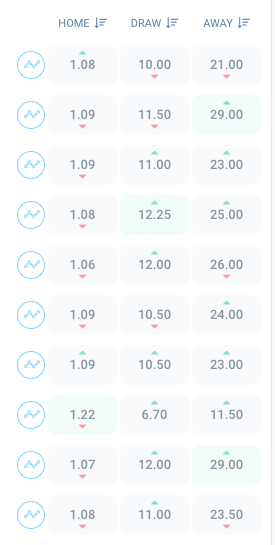

### Betting Scenario
You're considering betting €100 on Napoli to win against Sampdoria. The betting odds offered for Napoli to win are 1.08. This means that for every €1 you bet on Napoli, you will get €1.08 back if Napoli wins. The total payout would be your original bet plus the winnings.

For example, if we were to bet 100€ on Napoli to win, we would receive the original amount plus 100\*1.08= €8 should they win (of course, we would lose our €100 if they didn't win). 

In [87]:
bet_amount = 100
odds_napoli_win = 1.08

# Calculate the total payout (original bet + winnings)
total_payout = bet_amount * odds_napoli_win

# Calculate the winnings only
winnings = total_payout - bet_amount

print(f"Total Payout if Napoli wins: €{total_payout}")
print(f"Winnings: €{winnings}")


Total Payout if Napoli wins: €108.0
Winnings: €8.0


Now, how can we compare these prices to the probabilities returned by our model? Well, decimal odds can be converted to the probabilities quite easily: it's simply the inverse of the decimal odds. For example, the implied probability of Napoli winning is 1/1.08 (=0.926- our model put the probability at 0.903).

### Converting Decimal Odds to Implied Probability
The implied probability is the inverse of the decimal odds. It represents the probability implied by the odds being offered.

In [88]:
implied_probability_napoli_win = 1 / odds_napoli_win

print(f"Implied Probability of Napoli winning: {implied_probability_napoli_win:.3f}")


Implied Probability of Napoli winning: 0.926


### Comparing to Model's Probability

In [92]:
# Napoli Win
model_probability_napoli_win = np.sum(np.tril(nap_sam, -1))

print(f"Model's Probability of Napoli winning: {model_probability_napoli_win:.3f}")

Model's Probability of Napoli winning: 0.904


### Explenation
- **Implied Probability**: The probability derived from the betting odds, indicating how likely the betting market thinks Napoli will win.
- **Model's Probability**: The probability estimated by our Poisson regression model based on historical data.

By comparing these two probabilities, you can assess whether the bet offers value. A value bet exists when you believe the probability of an event happening is greater than the probability implied by the odds.


In [91]:
if model_probability_napoli_win > implied_probability_napoli_win:
    print("Betting on Napoli offers value.")
else:
    print("Betting on Napoli does not offer value.")


Betting on Napoli does not offer value.


So, we have our model probabilities and (if we trust the exchange) we know the true probabilities of each event happening. Ideally, our model would identify situations the market has underestimated the chances of an event occurring (or not occurring in the case of lay bets). 

For example, in a simple coin toss game, imagine if you were offered \$2 for every $1 wagered (plus your stake), if you guessed correctly. The implied probability is 0.333, but any valid model would return a probability of 0.5.

In a betting scenarios, what we're describing is the concept of finding **"value"** in betting odds. 

Value occurs when the probability estimated by your model (or your analysis) of an event happening is greater than the probability implied by the bookmaker's odds. 

**This discrepancy means that, over the long term, betting on such outcomes should yield a profit**. 

Let's break down the coin toss example and apply this concept to understand it better.

**OFFER**: If you bet 1€ on the outcome of a coin toss, and you guess correctly, you are offered a total payout of 3€. This total includes your original 1€ stake plus 2€ in winnings.

In [97]:
decimal_odds = 3.00
implied_probability = 1 / decimal_odds
print(f"Implied Probability: {implied_probability:.3f}")

Implied Probability: 0.333


### Understanding the Value in This Bet

Given a fair coin (assuming it's perfectly balanced and there's no bias in the toss), the true probability of either outcome (heads or tails) is 0.5, or 50%.

Comparing the true probability to the implied probability:

- **True Probability of Winning**: 0.5 (50%)
- **Implied Probability from Odds**: 0.333 (33.3%)

The true probability of winning (50%) is higher than the implied probability (33.3%). This discrepancy indicates that the bet offers value because the payout more than compensates for the risk according to the true odds of the event.

In [98]:
true_probability_coin_toss = 0.5  # 50%

if true_probability_coin_toss > implied_probability:
    print("The bet offers value.")
else:
    print("The bet does not offer value.")

The bet offers value.


Given the true probability of a fair coin toss, this bet indeed offers value because you are being paid out more than the true odds of the event occurring. Betting in such scenarios where the payout odds are more favorable than the true odds of the event would, theoretically, yield a positive return over many bets.

## Something's Poissony

Statistically speaking, is a Poisson distribution even appropriate? Our model was founded on the belief that the number goals can be accurately expressed as a Poisson distribution. If that assumption is misguided, then the model outputs will be unreliable. Given a Poisson distribution with mean $\lambda$, then the number of events in half that time period follows a Poisson distribution with mean $\lambda$/2.

**In football terms, according to our Poisson model, there should be an equal number of goals in the first and second halves. Unfortunately, that doesn't appear to hold true**.

In [99]:
sa_2223_halves = pd.read_csv("sa-2223.csv")
sa_2223_halves = sa_2223_halves[['FTHG', 'FTAG', 'HTHG', 'HTAG']]
sa_2223_halves['FHgoals'] = sa_2223_halves['HTHG'] + sa_2223_halves['HTAG']
sa_2223_halves['SHgoals'] = sa_2223_halves['FTHG'] + sa_2223_halves['FTAG'] - sa_2223_halves['FHgoals']
sa_2223_halves = sa_2223_halves[['FHgoals', 'SHgoals']]
sa_2223_halves.mean()

FHgoals    1.155263
SHgoals    1.407895
dtype: float64

The assumption that goals are scored at a constant rate throughout the match is a **simplification**. In reality, various factors can cause the rate of goal scoring to vary, including strategic changes, player fatigue, and psychological factors among many others.

The above code calculates the mean number of goals scored in the first half (`FHgoals`) and the second half (`SHgoals`) of matches in the Serie A 2022/23 season. 

**If the Poisson model's assumption were perfectly accurate, we'd expect these means to be approximately equal, assuming the first and second halves are of equal duration and no significant change in the rate at which goals are scored.**

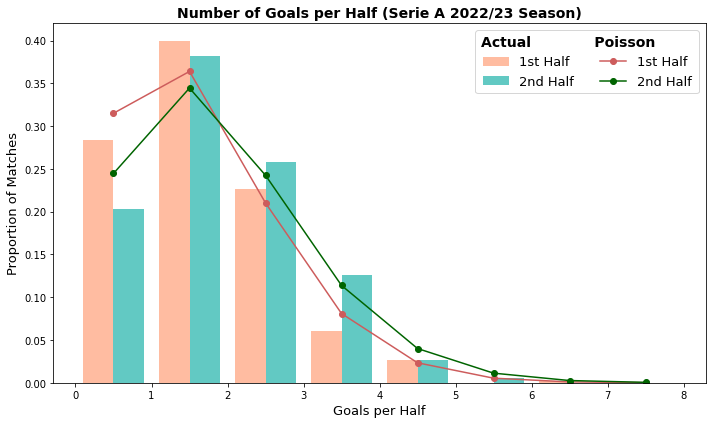

In [116]:
poisson_halves_pred = np.column_stack([[poisson.pmf(i, sa_2223_halves.mean()[j]) for i in range(8)] for j in range(2)])

plt.figure(figsize=(10, 6))

plt.hist(sa_2223_halves.values, range(9), 
         alpha=0.7, label=['1st Half', '2nd Half'], density=True, color=["#FFA07A", "#20B2AA"])

pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_halves_pred[:,0],
                  linestyle='-', marker='o', label="1st Half", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_halves_pred[:,1],
                  linestyle='-', marker='o', label="2nd Half", color = '#006400')

leg = plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Actual             Poisson        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i for i in range(9)], [i for i in range(9)])
plt.xlabel("Goals per Half", size=13)
plt.ylabel("Proportion of Matches", size=13)
plt.title("Number of Goals per Half (Serie A 2022/23 Season)", size=14, fontweight='bold')
# plt.ylim([-0.004, 0.4])  # Removed to allow automatic y-axis adjustment

plt.tight_layout()

# Save the figure as a PDF before showing it
plt.savefig('number_of_goals_per_half_serie_a_2223.pdf', bbox_inches='tight')

plt.show()

Well, there are indeed limitations of the univariate Poisson model for predicting football match outcomes, however the result are pretty impressive for getting start with more sophisticated. 

The takeaway here is that goals scored in football matches may not perfectly adhere to the assumptions of a Poisson distribution—such as the constant rate of events happening independently across the match duration—opens the door to exploring more sophisticated models. Let's briefly discuss some implementations:

### Bivariate Poisson Distribution
The bivariate Poisson distribution can model the number of goals scored by two competing teams simultaneously, taking into account the correlation between the scoring rates of the two teams. This could address scenarios where the scoring of one team influences the scoring rate of the other, which is a limitation in the univariate Poisson model where the events (goals scored by each team) are treated as independent.

### Weibull Distribution
The Weibull distribution is another alternative that has been proposed for modeling football scores. Unlike the Poisson distribution, which assumes a constant rate of scoring throughout the match, the Weibull distribution can accommodate variations in the scoring rate over time. This could potentially provide a better fit for data that exhibit patterns like an increasing likelihood of scoring as the match progresses, which could be due to factors like fatigue or strategic changes.

### Moving Forward
Exploring these more complex models involves addressing additional challenges, such as estimating more parameters and requiring more sophisticated statistical techniques. However, the potential for achieving a more accurate representation of the underlying processes that drive football match outcomes can make this complexity worthwhile. 

Future research and blog posts could focus on:
- **Modeling Correlations**: Developing bivariate Poisson models to better capture the interactions between teams' scoring rates.
- **Time-Dependent Rates**: Using the Weibull distribution or other time-dependent models to reflect the changing dynamics within a game.
- **Validation and Comparison**: Comparing the predictive performance of these models against the simple Poisson model and against each other, using historical match data.
- **Incorporating More Data**: Beyond goals scored, incorporating other factors such as team form, head-to-head performance, player statistics, and even in-match events (e.g., red cards, substitutions) could enhance the model's accuracy.

The journey from a simple model to a more refined and accurate one is a common path in statistical modeling and machine learning. Each iteration builds on the lessons learned from previous models, guided by both data and theory, toward a more nuanced understanding and prediction of complex phenomena like football matches.